# Tutorial 1: Land-cover classification

In this tutorial we are going to explore the power of the **Google Earth Engine** through classifying land-use categories on satelite imagery. In particular, we will focus on supervised classification using methods from frequentist statistics. Supervised classification refers to the process of using a training dataset with known labels to guide a mathematical classifier in the task of labeling spectral space. They key characteristic is that the training dataset guides (or “supervises”) the labeling.

The `Classifier` package within the **Google Earth Engine** handles supervised classification by traditional ML algorithms running in Earth Engine. We will be looking at three classifiers, namely logistical regression, decision trees, and random forests. The workflow for classification is as follows:

    1. Collect training data. Assemble features which have a property that stores the known class label and properties storing numeric values for the predictors.
    2. Instantiate a classifier. Set its parameters if necessary.
    3. Train the classifier using the training data.
    4. Classify an image or feature collection.
    5. Estimate the classification error with independent validation data.
    6. Test the trained and validated classifier on new, unseen data
    
## Important before we start
<hr>
Make sure that you save this file before you continue, else you will lose everything. To do so, go to Bestand/File and click on Een kopie opslaan in Drive/Save a Copy on Drive!

Now, rename the file into Week4_Tutorial1.ipynb. You can do so by clicking on the name in the top of this screen.

## Learning Objectives
<hr>

- Understand how one can extract data from **Google Earth Engine**.
- Know how to visualize data from **Google Earth Engine** in Python.
- Understand and apply a supervised classification algorithm.
- Create training data and a simple classifier.
- Compare and judge the performance of a land-use classification model.

P.S. we will <mark>mark</mark> important machine learning so you can keep track of the most important terms.

<h2>Tutorial Outline<span class="tocSkip"></span></h2>
<hr>
<div class="toc"><ul class="toc-item">
<li><span><a href="#introducing-the-packages" data-toc-modified-id="1.-Introducing-the-packages-2">1. Introducing the packages</a></span></li>
<li><span><a href="#extracting-and-exploring-landsat-8-data" data-toc-modified-id="2.-Extracting-exploring-landsat-3">2. Extracting and exploring Landsat-8 data</a></span></li>
<li><span><a href="#create-training-data-using-corine-land-cover" data-toc-modified-id="3.-Create-training-data-4">3. Create training data using Corine Land Cover</a></span></li>
<li><span><a href="#train-the-classifier-using-corine-land-cover" data-toc-modified-id="4.-Classifier-CLC-5">4.-Train the classifier using Corine Land Cover</a></span></li>
<li><span><a href="#classify-the-landsat-8-using-corine-land-cover" data-toc-modified-id="5.-Classify-CLC-6"> 5. Classify the Landsat-8 using Corine Land Cover</a></span></li>
<li><span><a href="#classify-the-landsat-8-using-esa-worldcover" data-toc-modified-id="6.-Classify-ESA-7"> 6. Classify the Landsat-8 using ESA WorldCover</a></span></li>
<li><span><a href="#analyze-and-assess-your-landsat-8-land-cover-map" data-toc-modified-id="6.-Analyze-LLC-7"> 7. Analyze and assess your Landsat-8 land cover map</a></span></li></ul></div>

## 1. Introducing the packages
<hr>

Within this tutorial, we are going to make use of the following main packages:

[**ee**](https://developers.google.com/earth-engine/guides/python_install) is a Python package to use the the Google Earth Engine.

[**geemap**](https://geemap.org/) is a Python package for interactive mapping with the Google Earth Engine.

Now we will import these packages in the cell below:

In [ ]:
import os
import random
import numpy as np

import ee
import geemap
import matplotlib.pyplot as plt

Finally, let's fix all of our random number generators. This will make our experiments reproducible.

In [ ]:
### Set global seeds ###
seed = 123
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

## 2.Accessing Landsat-8 data from Google Earth Engine
<hr>

You will notice that you need to authorize ourselves to be able to use the Google Earth Engine. To do so, we will first have to register ourselves. on the website of the [Google Earth Engine](https://earthengine.google.com/). Here, make a project and remember the project ID.

Next, you will have to add it to your Colab notebook as a secret:
1. Cick the `key` button on the left-hand side of the Colab panel
2. Press *add new secret*
3. Allow notebook access, set the Name to `EE_PROJECT_ID`, and the Value to the name of your EE project ID.

Alternatively, you can authorize your project as follows, but then be aware that anyone observing the notebook can see your project name, which is potentially a security issue.

In [ ]:
ee.Authenticate()
ee.Initialize(project="YOUR_PROJECT_NAME")

Then, run the code below to load a basemap and to test if you set your credentials right. You can choose any location in Europe, but the code below will show the coordinates we have selected for the Netherlands. Feel free to change them.

In [ ]:
map = geemap.Map(height=800,width=700,center=[52.37,4.5],zoom=7)
map

Now that we have succesfully managed to see a map of the Netherlands, let's load a Landsat-8 satellite image to our project. Landsat-8 is the 8th iteration of the American Landsat project, which has continuous records going back 40 years (!), which makes it the longest continuous satellite mission.

The code below executes the following steps:
1. Look for all images that intersect our point in the Netherlands
2. Filter it by the year 2015
3. Sort by cloud cover, lower = better
4. Select the least cloudy image, and load all bands

In [ ]:
point = ee.Geometry.Point([5.0, 51.37])

image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(point)
    .filterDate('2015-01-01', '2015-12-31')
    .sort('CLOUD_COVER')
    .first()
    .select('SR_B[1-7]')
)


The values in each band are between 1 and 65,535, the 16-bit unsigned integer limit. The values represent the `surface reflection`, the fraction of light that is reflected at each pixel location.

**Q1: Why is the `surface reflection` given as an integer value, rather than a floating point (decimal) value? What are the practical benefits of storing satellite image data this way?**

<br>

Now, let's visualize this image in colours that are natural to the human eye, using Red-Green-Blue (RGB) bands.

**Q2: Which band names should be added to the list to visualize the image with in red-green-blue colours?**

HINT: [This page contains the documentation, where you can find the answer](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2)

In [ ]:
bands = ['SR_B4', 'SR_B3', 'SR_B2'] # Fill in this list yourself
vis_params = {'max': 25000, 'bands':bands} # Limit upper range so you can see detail

map.centerObject(point, 8)
map.addLayer(image, vis_params, "Landsat-8")
map

As we have specified that we wanted landsat data with as little clouds as possible, let's check the data and the actual cloud cover:

In [ ]:
print(ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo())
print("cloud cover:", image.get('CLOUD_COVER').getInfo())

Now that we have the image, let's add some indices to add some extra information for the model. Together with the raw spectral values, these will be our <mark>input variables</mark>, from which the model will learn how to fit to the reference values.

In [ ]:
# Add the bands you need yoursef in the select functions
dvi = image.select('...').subtract(image.select('...')).rename('DVI')
image = image.addBands(dvi)

 # Compute the NDVI yourself - check the docs if needed
ndvi = ...
image = image.addBands(ndvi)

**Q3: Which other indices like the NDVI could be useful to add here, and why? Add at least one more to the image.**

**!!! Don't forget to rename the index, and to add it later in the exercise !!!**

In [ ]:
my_index = ...
image = image.addBands(my_index)

For the modelling, we will use reflectance from the optical, NIR, and SWIR bands (SR_B2 - SR_B7), as well as the indices we derived.

In [ ]:
# Use these bands for prediction
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
indices = ['NDVI', 'DVI'] # Add your index(es) band here
img_bands = [*bands, *indices]

## 3.Create reference data using Corine Land Cover
<hr>

Now that we have had a look at the images we will be working with, we can define the <mark>reference data</mark> (also referred to as *labelled data* and *ground truth* data) that we're going to use to train classification models. The training data is used to <mark>fit</mark> models. A fitted or trained models can then be used to predict on a new dataset to determine how well it works on unseen data.

For example, land cover training data will contain examples of each class in the study’s legend. Based on these labels, the classifier can predict the most likely land cover class for each pixel in an image. This is an example of a categorical classification and the training labels are therefore categorical. By contrast, a continuous variable (e.g. percent tree cover) can be predicted using continuous training labels.

There are several ways you can create a region to fence off your dataset:

- Draw a shape (e.g., rectangle) on the map and the use `region = Map.user_roi`
- Define a geometry, such as `region = ee.Geometry.Rectangle([-122.6003, 37.4831, -121.8036, 37.8288])`
- Create a buffer zone around a point, such as `region = ee.Geometry.Point([-122.4439, 37.7538]).buffer(10000)`
- If you don't define a region, it will use the image footprint by default

In our case, we use the complete extent of the image for training and evaluating our models.

Our reference data is the CORINE Land Cover dataset (CLC), a pan-European dataset made from a combination of harmonized national land cover inventories. Fortunately, we can use GEE to directly access CLC data. We also use the `.clip()` function in which we define that we specifically only want to see the same area as the Landsat-8 image we already selected, rather than the area of our map interface.

In [ ]:
CLC = ee.Image('COPERNICUS/CORINE/V20/100m/2012').select('landcover').clip(image.geometry())
map.addLayer(CLC, {}, 'CLC')
map

Now we are going to make the training dataset. We do so by randomly sampling pixels from the image array that coincide with a CLC reference pixel.

In the `sample()` function, we have to specify multiple arguments:

- Through the `region`argument we specify the geographic boundary of our training dataset.
- Through the `scale` argument we specify the size of the points for our sample (30 would indicate 30m).
- Through the `numPixels` argument we specify how many pixels we want to extract. More pixels means more training time needed, but a higher expected accuracy. Wouldn't recommend setting this to more than 10k.
- Through the `seed` argument we specify which random selection order we want. Through using a seed, you can always reproduce your results.
- Through the `geometries` argument we specify whether we want to extract the geometries as well. In most cases you want to retain the geometry, so specify `true`.

In [ ]:
# Fill in the arguments here yourself
lc_points = CLC.sample(
    **{
        'region': image.geometry(),
        ...
    }
)

Let's check how many points we got for our sample set, and which information a single point contains.

In [ ]:
print("total number of points:", lc_points.size().getInfo())
print(lc_points.first().getInfo())

Take note of the final column, the *'landcover'* class. It contains the land cover associated with each individual pixel. Try looking up some information about it to understand what it is that we are trying to classify.

**Q4: Which land cover class is `211`, and which 'superclasses' (more general classes) does it fall under? Do you think the LC classes of CORINE could be globally applicable, why/why not?**

While the third level of LC classes are very detailed, they contain a lot of uncertainty, and they are difficult for a model to learn. Instead, let's first generalize the land cover classes to the second level of the hierarchy. For this, we will finish the following function that we will apply to the column.

In [ ]:
def generalize_clc_class(feature):
    lc_value = feature.get('...') # Which feature property needs to be accessed?
    l2_hierarchy_lc = ee.String(lc_value).slice(...) # TODO: How should this be sliced to retain the second-level hierarchy?
    return feature.set(..., l2_hierarchy_lc) # which feature property needs to be set?

In [ ]:
# TODO: Look up the GEE function to run the function over each points
lc_reference_pts = lc_points.map(generalize_clc_class) # Students do this themselves

## 4.Split dataset into folds
<hr>

In the previous step we made our co-located dataset consisting of reference data (CLC land cover at the 2nd level hierarchy), and Landsat-8 pixels with additional calculated values. The next step is to partiton the dataset into training and validation splits, so that we can train and evaluate models. In short, the <mark>training split</mark> is used for a model to fit to the input data, while the <mark>validation split</mark> is used to test if the learned model can predict well on new, unseen data.

 Later in the notebook there will also be a <mark>test split</mark> on which we evaluate the final performance of models.

In [ ]:
# This property of the table stores the land cover labels
label_col = 'landcover'

# Sample points for validation / training split datasets
sample = lc_reference_pts.randomColumn();
training_sample = sample.filter('random <= 0.8');
validation_sample = sample.filter('random > 0.8');

train_data = image.select(img_bands).sampleRegions(
    **{'collection': training_sample, 'properties': [label_col], 'scale': 100}
)

val_data = image.select(img_bands).sampleRegions(
    **{'collection': validation_sample, 'properties': [label_col], 'scale': 100}
)

**Q4: What are the downsides of using a sample randomized 80/20 training/validation split like this? Can you think of other ways to partition the dataset which would be better?**

Finally, let's visualize a single imge pixel to make sure that everything is included as expected. Contrary to what some might say, preparing and organizing your dataset takes up the bulk of your time when working with machine learning models. **Always double-check your dataset before training, or you'll find yourself wasting a lot of time**!

In [ ]:
# Print the first feature in the training collection
print(train_data.first().getInfo())

As can be seen, each datapoint contains reflectance values from the Landsat-8 image, the indices we defined, and a land cover reference label.

#### Converting to scikit-learn compatible data
The GEE package provides built-in functions for a couple of popular models, so in principle we can continue working entirely within GEE. However, we're interested in teaching you re-usable machine learning skills. Therefore, we run our models using scikit-learn, Python's most popular package for standard ML models. For this purpose, we should convert our data into a data structure that is compatible with this package.

In [ ]:
import pandas as pd

def feature_collection_to_lists(features, input_features, label_col):
  # Convert data to Pandas for use with scikit
  features_list = features.toList(features.size()).getInfo()
  features_list = [feature['properties'] for feature in features_list] # Unpack from dictionary
  features_df = pd.DataFrame(features_list)

  inputs = features_df[input_features] # Image pixel values for training
  labels = features_df[label_col] # Land cover values for validation
  return inputs, labels

x_train, y_train = feature_collection_to_lists(train_data, img_bands, label_col)
x_val, y_val = feature_collection_to_lists(val_data, img_bands, label_col)

## 5. Training models
<hr>

Now that we have our dataset split into training, validation, and testing samples, we can begin training models. But wait up! Before we start throwing increasingly sophisticated models at the problem, we have to understand how statistical learning works in the first place. We'll consider a number of frequentist statistical models of increasing complexity. We'll first take a look at a basic model, namely logistical regression. Next, we consider decision trees, and finally we consider a more sophisticated tree-based classifier, namely random forest models.

### 5a. Logistic Regression
---
Let's first consider what is possibly the simplest approach in frequentist statistics for this task - <mark>Logistic Regression</mark>. Similar to a *Linear Regression* model, a logistic regression model fits each of the input features to the reference data based on the total set of datapoints in the training dataset. It outputs the probability that a given datapoint belongs to a given label class, e.g. the probability that a given sample belongs to the `urban fabric` class. It creates a distinct *'S-shaped'* probability distribution, courtesy of the sigmoid function used to bound it.

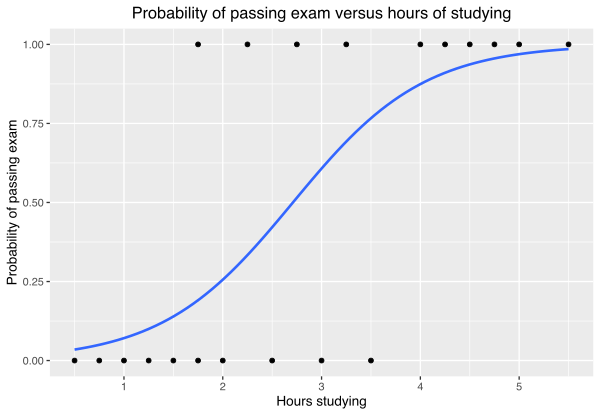

(Image courtesy of Wikimedia)

**Q5: Why can't we use a regular linear regression to regress the probabilities of each class, why do we have to use a sigmoid function to bound our predictions? Which kinds of problem(s) could using a linear regression model cause for this case?**

Let's fit the model to our training data and evaluate how well it performs on the training split using a straightforward overall accuracy measures, where we simply count the ratio of correct positives. Under the hood, we assign a `1` or a `0` to each class, which we call <mark>one-hot encoding</mark> (as in - only one of the labels is *hot*, with a value of `1`). The model is then optimized to predict a confidence for each class separately which indicates if the given class is present or not. In the scikit implementation, the most confident class (closest to `1`) gets assigned to the datapoint. Let's try it out!

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, cohen_kappa_score

# Train a logistic regression model
model = LogisticRegression()
model.fit(x_train.values, y_train.values)

# Predict and evaluate
train_y_pred = model.predict(x_train)
train_accuracy = accuracy_score(train_y_pred, y_train)
print("Training accuracy:", round(train_accuracy, 3))

Okay, a little under 50% accurate, that's reasonably good. But is it better than random guessing? For this, we use Cohen's Kappa. The **Kappa Coefficient** is generated from a statistical test to evaluate the accuracy of a classification. **Kappa** essentially evaluates how well the classification performed as compared to just randomly assigning values, i.e. did the classification do better than random. The **Kappa Coefficient** can range from -1 to 1. A value of 0 indicated that the classification is no better than a random classification. A negative number indicates the classification is significantly worse than random guessing. A value of to 1 indicates that the predicted values are equal to the ground truth, therefore not being the product of any random guessing.

By the way, in professional parlay, we refer to measures as the `accuracy` and `Cohen's Kappa` as <mark>performance metrics</mark>.

In [ ]:
train_kappa = cohen_kappa_score(train_y_pred, y_train)
print("Training Kappa:", round(train_kappa, 3))

Looking good. It's not a perfect performance, but the model outperforms random guessing by a significant margin. Not bad for the simplest possible model with a fairly large number of target classes.

Now, let's see if it manages to predict well on pixels which it hasn't been trained for.

In [ ]:
val_y_pred = model.predict(x_val)

val_accuracy = accuracy_score(y_val, val_y_pred)
print("Validation accuracy:", round(val_accuracy, 3))

val_kappa = cohen_kappa_score(val_y_pred, y_val)
print("Validation Kappa:", round(val_kappa, 3))

**Q6: Interpret the results. What do you think of the performance on the validation set compared to training, is this an expected outcome, why/why not? Considering the random split we did, do you think this model could suitable for predicting in new, unseen regions?**

Before we move on, let's make two quick functions that we can re-use whenever we want to evaluate our models quickly. It will save us a lot of code re-use when iterating through candidate models.

In [ ]:
def train_model(model, x_val, y_val):
  ## Training ##
  model.fit(x_train.values, y_train.values)

  train_y_pred = model.predict(x_train)

  train_accuracy = accuracy_score(train_y_pred, y_train)
  print("Training accuracy:", round(train_accuracy, 3))

  train_kappa = cohen_kappa_score(train_y_pred, y_train)
  print("Training Kappa:", round(train_kappa, 3))
  return model

def validate_model(...):
  # Fill in and finish this function based on the above examples
  # Make sure to report both metrics

### 5b. Decision tree classifiers
---
Now that we have some experience with the simplest possible approach, let's talk about models which are a bit more clever - tree-based classfiers. First, we'll take a look at a standard <mark>decision tree model</mark>. It learns the best places to cut off the data to create the best separation between classes. As such, contrary to a logistic regression, a decision tree can approximate complex decision boundaries. Graphically, classification trees identify lines that successively split the data space to separate the training points into their classes, as shown below.

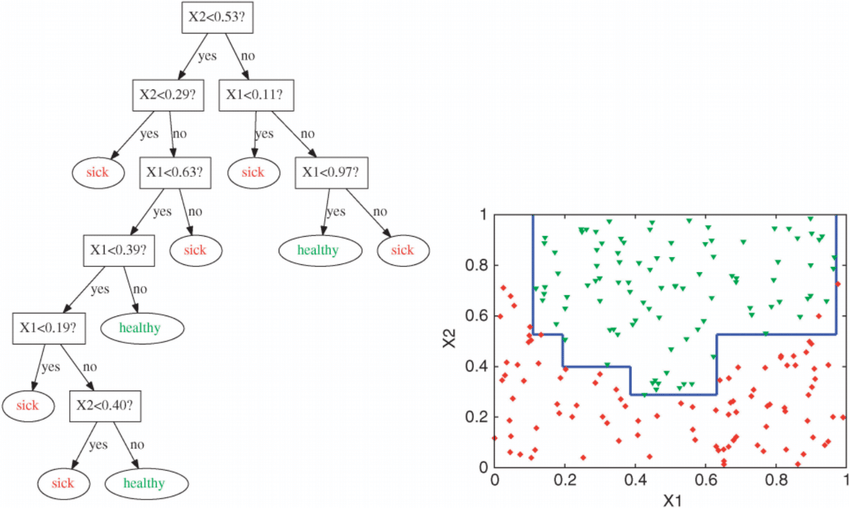

([Image courtesy of Clayton Miller](https://www.researchgate.net/publication/313720565_Screening_meter_data_Characterization_of_temporal_energy_data_from_large_groups_of_non-residential_buildings))

Let's repeat the process of training a model by using a decision tree classifier. This is a <mark>parametrized</mark> model, which means that there are certain decisions to make, which will affect the performance of the model. First, let's run it with the default settings, and you'll quickly see why it's important to pay attention to the parameters of your models.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier()
decision_tree_model = train_model(decision_tree_model, x_train, y_train)
validate_model(decision_tree_model, x_val, y_val)

This results in a very big contrast in the model's performance. How can it be that the model almost performs perfectly on the training dataset, but does poorly on the validation dataset? For the answer, [take a look at the documentation of the model](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). In particular, look at the parameters `max_depth` and `min_samples_split`. Use the docs and any other means at your disposal to answer the following question.

**Q7: In your own words, what is the effect of changing `max depth` and `min_samples_split`? How could these two parameters result in a perfect fit for the model on the training data?**

So now that we know about parameters, let's try setting these two parameters such that the model doesn't become hyper-specialized on the training dataset, at the cost of performance on unseen data. Experiment with different parameter settings in the code box below.

In [ ]:
# Try it yourself a couple of times: Instantiate the model and change the parameters.
decision_tree_model = ...
decision_tree_model = train_model(decision_tree_model, x_train, y_train)
validate_model(decision_tree_model, x_val, y_val)

**Q8: Report the settings of the best-performing model on the validation dataset, along with the validation accuracy and Kappa. Why do you think the parameters you chose ended up working better than the default settings, which produced a perfect fit on the training dataset?**

### 5c. Random Forests
---

> *Do you know what is better than one tree? Two trees! And what is better than two trees? A forest!*

*Tin Kam Ho, inventor of Random Forest models, 1995* (probably).

While the quote above is a tongue-in-cheek fake quote, the author of <mark>Random Forest (RF)</mark> models clearly was onto something. What if we use multiple of decision trees, then take their average prediction? This is an <mark>ensemble</mark> approach, where the rationale is that we can achieve a better performance by averaging multiple prediction models. In the case of RF, we ensemble individual decision trees, and through some tricks (i.e. randomly not giving trees access to some input variables), we produce trees which have slightly different prediction characteristics.

This intuitive approach has been a mainstay of machine learning for remote sensing for decades, with good performance even on small datasets. In fact, up until very recently they were still preferred over sophisticated deep learning model for niche tasks with a small amount of datapoints, due to their ease of use and efficiency! Bigger is certainly not always better. So let's try them out!

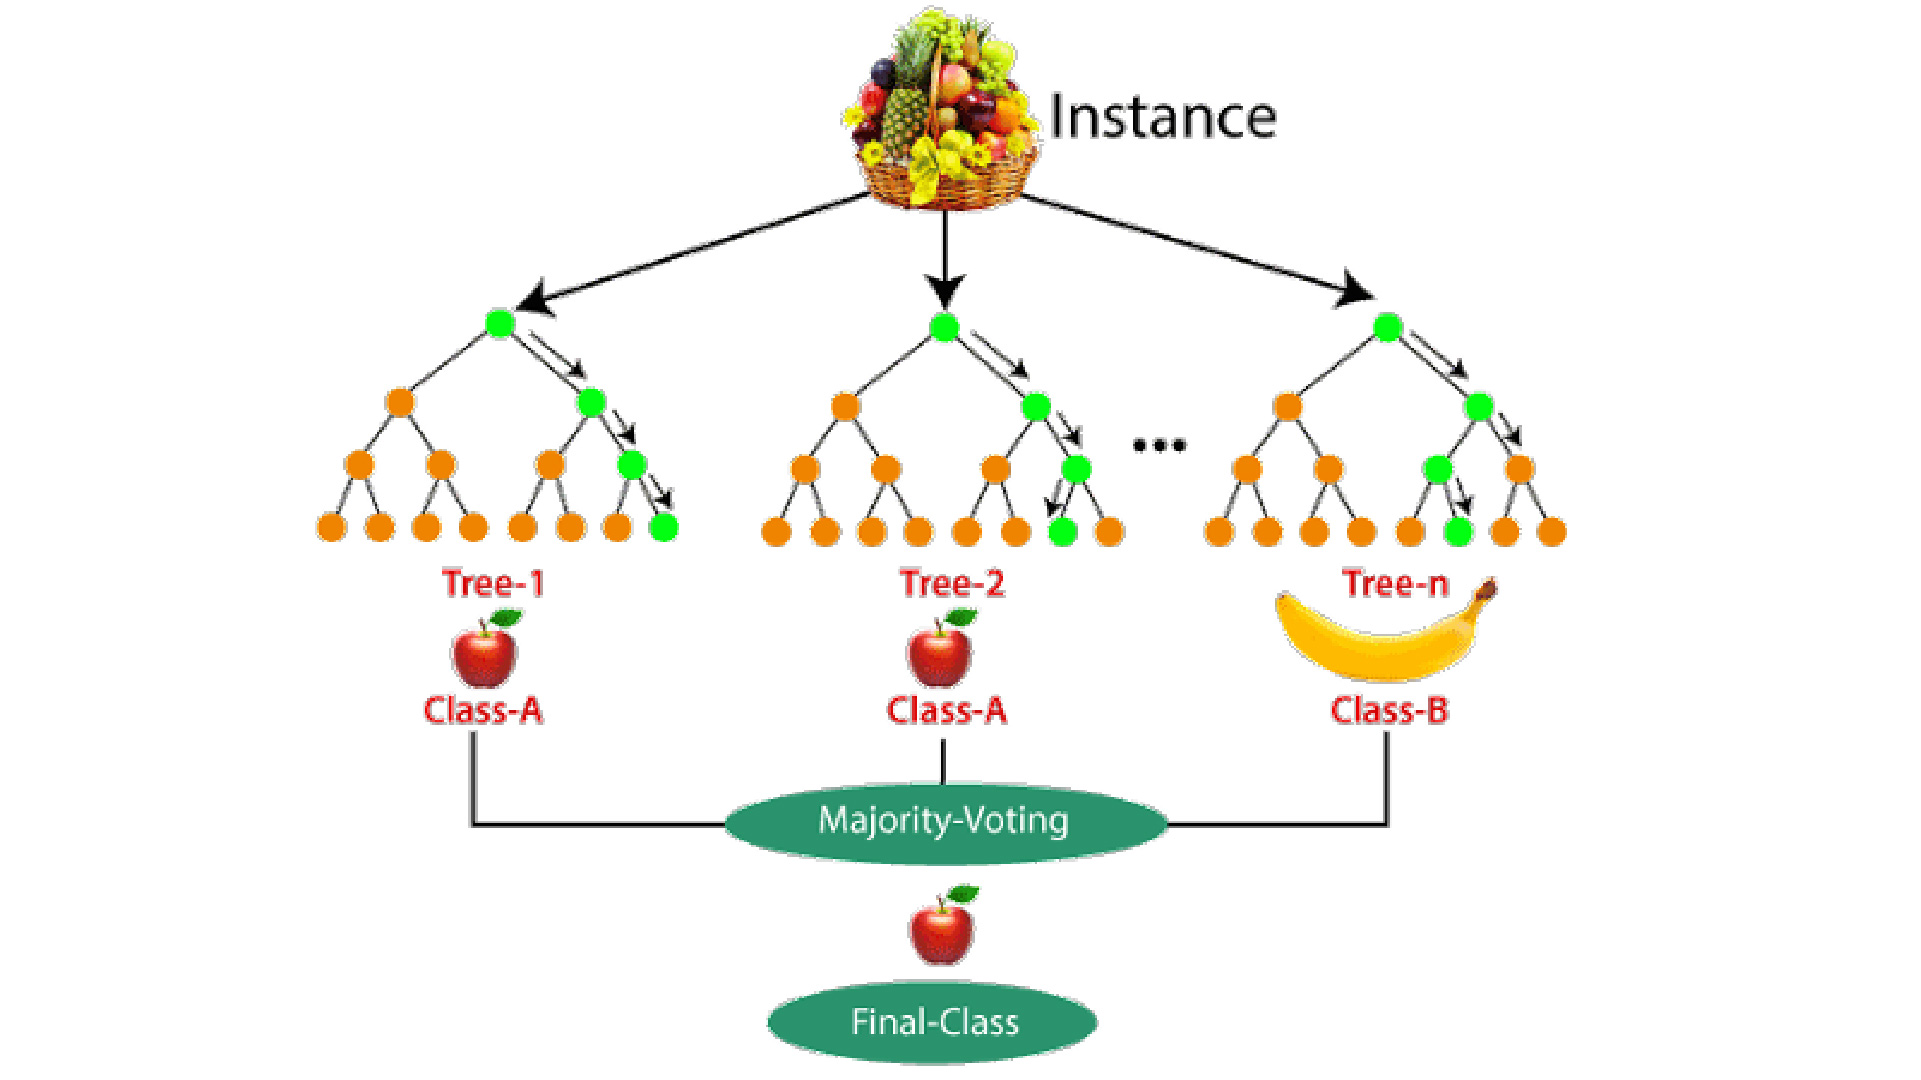

([Courtesy of Sruthi E.R.](https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/))

[First, take a look at the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), where you'll see that (logically) it is a parametrized model too. To keep it simple, let's focus on two important parameters while fixing the rest. We focus on `min_samples_split`, and `n_estimators`. You know the first one, and by its name you can reasonably figure out that `n_estimators` is the number of trees we'd like to use.

Rather than guessing which parameters are best like we did before, we will write a function that will help us to find the best parameters based on a <mark>grid search</mark>. With a grid search optimization approach, we iterate over all combinations of parameters to find the best one of the set.

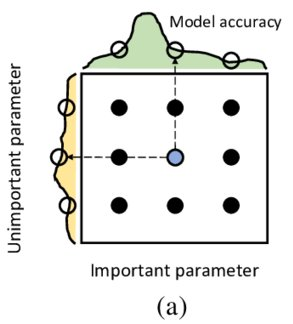

(A visual example of grid search, where parameter searching occurs in a grid with regular intervals. Adapted from [Pilario, Cao, and Shafiee](https://www.researchgate.net/publication/341691661_A_Kernel_Design_Approach_to_Improve_Kernel_Subspace_Identification))

In [ ]:
# RF Parameter choices. Change them as you see fit.
n_estimator_ranges = [10, 25, 50, 100, 250]
min_sample_ranges = [2, 5, 10, 25, 50]
total_combinations = len(n_estimator_ranges) * len(min_sample_ranges)

The following loop goes through all of the parameter combinations to measure their performance. In a nutshell, the code below performs the following steps:


1.   Instantiate two matrices, one for tracking performance, the other for time taken
2.   Iterate over the number of trees in the outer loop (estimators)
3.   Iterate over the number of splits per sample in the inner loop
4.   In the inner loop, we train our model on the dataset, measure time taken and performance, and insert these in the matrices

It can take a minute or two to complete running, so have a sip of coffee and wait patiently - after you finish filling in the code to complete it!

In [ ]:
from datetime import datetime
from tqdm import tqdm # fancy progress bar package
from IPython.display import clear_output

import numpy as np
from sklearn.ensemble import RandomForestClassifier

## Instantiate performance and time-keeping matrices
kappa_paramsearch = np.ndarray([len(n_estimator_ranges), len(min_sample_ranges)])
time_paramsearch = np.ndarray([len(n_estimator_ranges), len(min_sample_ranges)])

# Time-keeping function to track if the code runs correctly.
pbar = tqdm(total=total_combinations)

## Perform the parameter searching and keep track of performance/time
## We loop over all possible combinations of both parameters
for n_trees_index, n_trees in enumerate(n_estimator_ranges):
    for min_leaves_index, min_samples in enumerate(min_sample_ranges):
        ## Update our time keeping function
        pbar.set_description(f"n_trees: {n_trees}, min_leaves: {min_samples}")

        ## Initialize the random forest classifier - set maximum depth to 25
        model = ...

        ## Fit the classifier to the training data/labels and measure time taken
        start = datetime.now()
        model.fit(x_train.values, y_train.values)
        end = datetime.now()
        time_taken = float(f"{(end - start).seconds}.{round((end - start).microseconds, 2)}")

        ## Use the model to predict all of the validation pixels and calculate the Kappa
        val_y_pred = ...
        val_kappa = ...

        ## Store accuracies and time taken for this parameter combination
        kappa_paramsearch[n_trees_index, min_leaves_index] = round(val_kappa, 3)
        time_paramsearch[n_trees_index, min_leaves_index] = round(time_taken, 3)

        pbar.update()

# Clear the progress bar print(s) once it's done running
clear_output()

Let's have a look at which parameter combination provides the best performance, and how long it took to run each model.

In [ ]:
import matplotlib.pyplot as plt

## Dirty work-around for first label not showing when plotting
n_trees_labels = [0] + n_estimator_ranges
min_leaves_labels = [0] + min_sample_ranges

fig, (ax_acc, ax_time) = plt.subplots(1, 2, figsize=(total_combinations,total_combinations))

## Plot accuracy
ax_acc.set_title("Cohen's Kappa", weight='bold')
ax_acc.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_acc.set_xticklabels(n_trees_labels)
ax_acc.set_yticklabels(min_leaves_labels)
ax_acc.matshow(kappa_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot time taken
ax_time.set_title("Time Taken in Seconds", weight='bold')
ax_time.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_time.set_xticklabels(n_trees_labels)
ax_time.set_yticklabels(min_leaves_labels)
ax_time.matshow(time_paramsearch.T, cmap=plt.get_cmap('coolwarm'))

## Add text to accuracy plot
for t_i, t_val in enumerate(n_estimator_ranges):
    for l_i, l_val in enumerate(min_sample_ranges):
        ax_acc.text(t_i, l_i, s=kappa_paramsearch[t_i, l_i], ha='center')

## Add text to time plot
for t_i, t_val in enumerate(n_estimator_ranges):
    for l_i, l_val in enumerate(min_sample_ranges):
        ax_time.text(t_i, l_i, s=time_paramsearch[t_i, l_i], ha='center')

**Q9: Interpret and discuss the performance matrices above. What do you believe are the best parameters for the model, and why?**

Let's use one more trick to evaluate the performance of our model - a <mark>confusion matrix</mark>. It is a simple table which compares the reference labels with the model's predictions by looking at the mistakes made between all reference class combinations to determine which classes are most often confused.

It is evaluated through four metrics:

* True Positives (TP): The number of times the model correctly predicted the positive class.
* True Negatives (TN): The number of times the model correctly predicted the negative class.
* False Positives (FP): The number of times the model incorrectly predicted the positive class when it was actually negative (also called a "Type I error").
* False Negatives (FN): The number of times the model incorrectly predicted the negative class when it was actually positive (also called a "Type II error").

By looking at these values, you can understand how well your model is performing for each class, as well as which classes are confused most often.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = sorted(set(y_val))
cm = ... # Call the confusion_matrix here - figure out how to using the documentation
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

**Q10: Which classes are most often confused, and why do you think this is the case?**

(look at the CLC class labels for a more insightful discussion)

Finally, let's consider the topic of *interpretability*. That is, how easy is it to understand the reasoning behind a model's decisions. When you use a large number of trees, it is technically possible to understand exactly how decisions are made by analyzing the splits in each trees. However, this is a very time-consuming task, and not realistic to do in almost any scenario. How then can we make sense of our predictions, while still making use of its complex, non-linear performance benefits?

RF models have a built-in trick

Entropy is based on information theory. It quantifies the uncertainty or impurity in a set of data. A node with high entropy has a mix of different classes (high disorder), while a node with low entropy is more homogeneous (low disorder). In this context, a higher value means that removing the variable causes more disorder, so therefore the class is more important.

Gini coefficient (or Gini impurity) measures the probability of incorrectly classifying a randomly chosen element if it was randomly labeled according to the distribution of classes in the node. Like entropy, a higher Gini impurity for a given variable indicates that it is more important for the predictions of the model.

For more information, please have a look at the book [Introduction to Statistical Learning](https://www.stat.berkeley.edu/users/rabbee/s154/ISLR_First_Printing.pdf), page 312 discusses these metrics.

In [ ]:
## We train two models with the same parameter settings - one for entropy, and one for the GINI coefficient.
entropy_model = RandomForestClassifier(n_estimators=100, min_samples_split=10, max_depth=25, criterion='entropy')
entropy_model.fit(x_train.values, y_train.values)
features_entropy = entropy_model.feature_importances_

gini_model = RandomForestClassifier(n_estimators=n_trees, min_samples_split=min_samples, max_depth=25, criterion='gini')
gini_model.fit(x_train.values, y_train.values)
features_gini = gini_model.feature_importances_

Let's plot the results for the model trained using both of these metrics.

In [ ]:
## Make bar plots
x_axis = range(len(features_gini))
fig, (ax_gini, ax_entropy) = plt.subplots(1, 2, figsize=(10,10))
ax_gini.bar(x_axis, features_gini)
ax_gini.set_title("GINI coefficient per variable", weight='bold')
ax_entropy.bar(x_axis, features_entropy, color='darkgreen')
ax_entropy.set_title("Entropy per variable", weight='bold')

## Add labels to the bars
for index, label in enumerate(img_bands):
    ax_gini.text(index, y=features_gini[index]+0.003, s=label, ha='center', rotation=90)
for index, label in enumerate(img_bands):
    ax_entropy.text(index, y=features_entropy[index]+0.003, s=label, ha='center', rotation=90)

**Q10: What is depicted in the plots above? What do the metrics tell us about the variables we used? How would you interpret the results of these plots, and based on them, would you remove any variables?**


# 6. Measuring test set performance
---
We've trained and validated several models, now it's time to find out how they perform when we provide it with new data one last time. This is called model <mark>testing</mark>. We go through this step only once, and this is generally the metrics that we add to the paper. It's because we used the validation set to find a set of parameters that should work well on new data, so we shouldn't then fine-tune on top of the test set.

So let's re-make our dataset, this time with an image taken more recently in 2018, and with CLC reference data from 2018. This is a fairly substantial challenge, because we're trying to see if we can use the model to update our land cover maps. Let's see how it goes...

In [ ]:
## Initialize the random forest classifier
model = ...

## Fit the classifier to the training data/labels and measure time taken
...

Sample new Landsat-8 image from 2018 in the same area

In [ ]:
test_image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(point)
    .filterDate('2018-01-01', '2018-12-31')
    .sort('CLOUD_COVER')
    .first()
    .select('SR_B[1-7]')
)
map.centerObject(point, 8)
map.addLayer(test_image, vis_params, "Landsat-8")
map

Add indices - you can add your own indices if you like.

In [ ]:
dvi = test_image.select('SR_B5').subtract(test_image.select('SR_B4')).rename('DVI') # Add the bands you need yoursef
test_image = test_image.addBands(dvi)

ndvi = test_image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI') # Add the bands you need yoursef
test_image = test_image.addBands(ndvi)

Sample CLC data in new area

In [ ]:
CLC = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(test_image.geometry())
### Use the same settings as during training. Take care not to load the 2012 version above here!
test_lc_points = CLC.sample(
    **{
        'region': test_image.geometry(),
        ...
    }
)
test_lc_reference_pts = test_lc_points.map(generalize_clc_class) # Students do this themselves

Make test dataset

In [ ]:
test_data = test_image.select(img_bands).sampleRegions(
    **{'collection': test_lc_reference_pts, 'properties': [label_col], 'scale': 100}
)
x_test, y_test = feature_collection_to_lists(test_data, img_bands, label_col)

We already have our trained model, and we're not supposed to re-train it on this image. Therefore, all that's left to do is to run this model and test its performance on this new dataset.

In [ ]:
## Use the model to predict all of the validation pixels
test_y_pred = model.predict(x_test)
test_accuracy = accuracy_score(test_y_pred, y_test)
print("Test set accuracy:", round(test_accuracy, 3))

test_kappa = cohen_kappa_score(test_y_pred, y_test)
print("Test Kappa:", round(test_kappa, 3))

In principle, the model's results on the test set are what we would report in a paper. Depending on your expectations, you might be surprised with the results of the model compared to the test set. However, it's important to remember a few things:
1.  We haven't played around much with the input variabes. There are more tricks that we could tap into that we haven't discussed (e.g. think about how important it is to see what happens around a pixel in order to determine what's happening inside it).
2.  There's a total of 15 output classes. This is a **hard** task for a simple model.
3.  We are not consistent with the time of year at which we're predicting, which for some land cover classes has a large impact on how it's perceived.
4.  We're training it on just 10'000 pixels. This is a limited amount for a hard task, and usually we'd prefer to use much more data.

And there's many more reasons we could list. The reality is that modelling is a hard task, and a lot of the trial-and-error and failed models get underreported in papers. By showing you the harsh realities of real-life, difficult modelling problems, we hope to have demonstrated that this type of modelling has strong potential, but also that it doesn't come easy. With that in mind, let's reflect a little bit on how we can do better. Please answer the question below, and we will provide feedback and discuss some of the answers.

**Q11: What are your thoughts on the final test set accuracy? Which factors of the image, reference data, and our workflow do you think affected the final performance of the model the most? How do you think the model workflow can be improved to provide better predictons?**

## Wrapping up
That's it for this practical. There's many more nuances we could get into, but we'd need another lecture or two if we want to cover them all. Hopefully this practical gave you some insights into what it means to run a machine learning pipeline. We also hope that you see now that machine learning isn't a fully-automatic magical problem-solving box, but that there are quite a lot of steps involved and decisions to make. It's up to you, the modeller, to make the right choices with regards to data set-up and model parameter choices. Since this tutorial is getting lengthy already, we unfortunately can't go into more detail on how to improve the model further, especially on the test set. We will provide feedback based on the questions, and provide general tips on what makes a successful ML pipeline. We also hope that this tutorial inspires you to look deeper into modelling, while retaining a critical outlook on what it is and what it can do!

and, remember...

> *All models are wrong, some are useful*

*George Box, 1976*
